## Environment Setup

In [8]:
"""
CELL 1: ENVIRONMENT SETUP
Run this cell first, then RESTART KERNEL before running other cells
"""

print("="*80)
print("ENVIRONMENT SETUP FOR T5 SUMMARIZATION PROJECT")
print("="*80)

print("\n[1/2] Installing/Upgrading required packages...")
print("This may take 2-3 minutes. Please wait...\n")

# Force reinstall with no dependencies to avoid conflicts
!pip uninstall -y transformers huggingface_hub
!pip install --no-deps transformers==4.30.2
!pip install --no-deps huggingface_hub==0.16.4
!pip install --upgrade tokenizers safetensors

# Install other required packages
!pip install --quiet rouge-score==0.1.2 evaluate==0.4.0

print("\n[2/2] Verifying installations...")
import transformers
import torch

print(f"✓ Transformers: {transformers.__version__}")
print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Download NLTK data
import nltk
nltk.download('punkt', quiet=True)
print("✓ NLTK punkt downloaded")

print("\n" + "="*80)
print("⚠️  CRITICAL: RESTART KERNEL NOW!")
print("="*80)
print("\nSteps:")
print("1. Click 'Kernel' → 'Restart Kernel' in the menu")
print("2. Wait for kernel to restart")
print("3. Then run Cell 2 (Data Exploration)")
print("="*80)

ENVIRONMENT SETUP FOR T5 SUMMARIZATION PROJECT

[1/2] Installing/Upgrading required packages...
This may take 2-3 minutes. Please wait...

Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: huggingface-hub 1.0.0rc2
Uninstalling huggingface-hub-1.0.0rc2:
  Successfully uninstalled huggingface-hub-1.0.0rc2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 81.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 kB 26.6 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.5.3
    Uninstalling safetensors-0.5.3:
      Successfully uninstalled safetensors-0.5.

## Data exploration and quality check

DATA EXPLORATION & QUALITY CHECK

[1/5] Loading datasets...
✓ Original dataset sizes:
  Train: 287,113
  Validation: 13,368
  Test: 11,490

[2/5] Checking for missing values...

Train set:
id            0
article       0
highlights    0
dtype: int64

Validation set:
id            0
article       0
highlights    0
dtype: int64

Test set:
id            0
article       0
highlights    0
dtype: int64

[3/5] Checking for duplicates...
Duplicates found:
  Train: 3,108
  Validation: 0
  Test: 2

✓ After removing duplicates:
  Train: 284,005 (removed 3,108)
  Validation: 13,368 (removed 0)
  Test: 11,488 (removed 2)

[4/5] Analyzing text lengths...

Article length statistics (characters):
count    284005.000000
mean       4034.914502
std        1955.068050
min          48.000000
25%        2585.000000
50%        3682.000000
75%        5116.000000
max       15925.000000
Name: article_length, dtype: float64

Summary length statistics (characters):
count    284005.000000
mean        295.102097
st

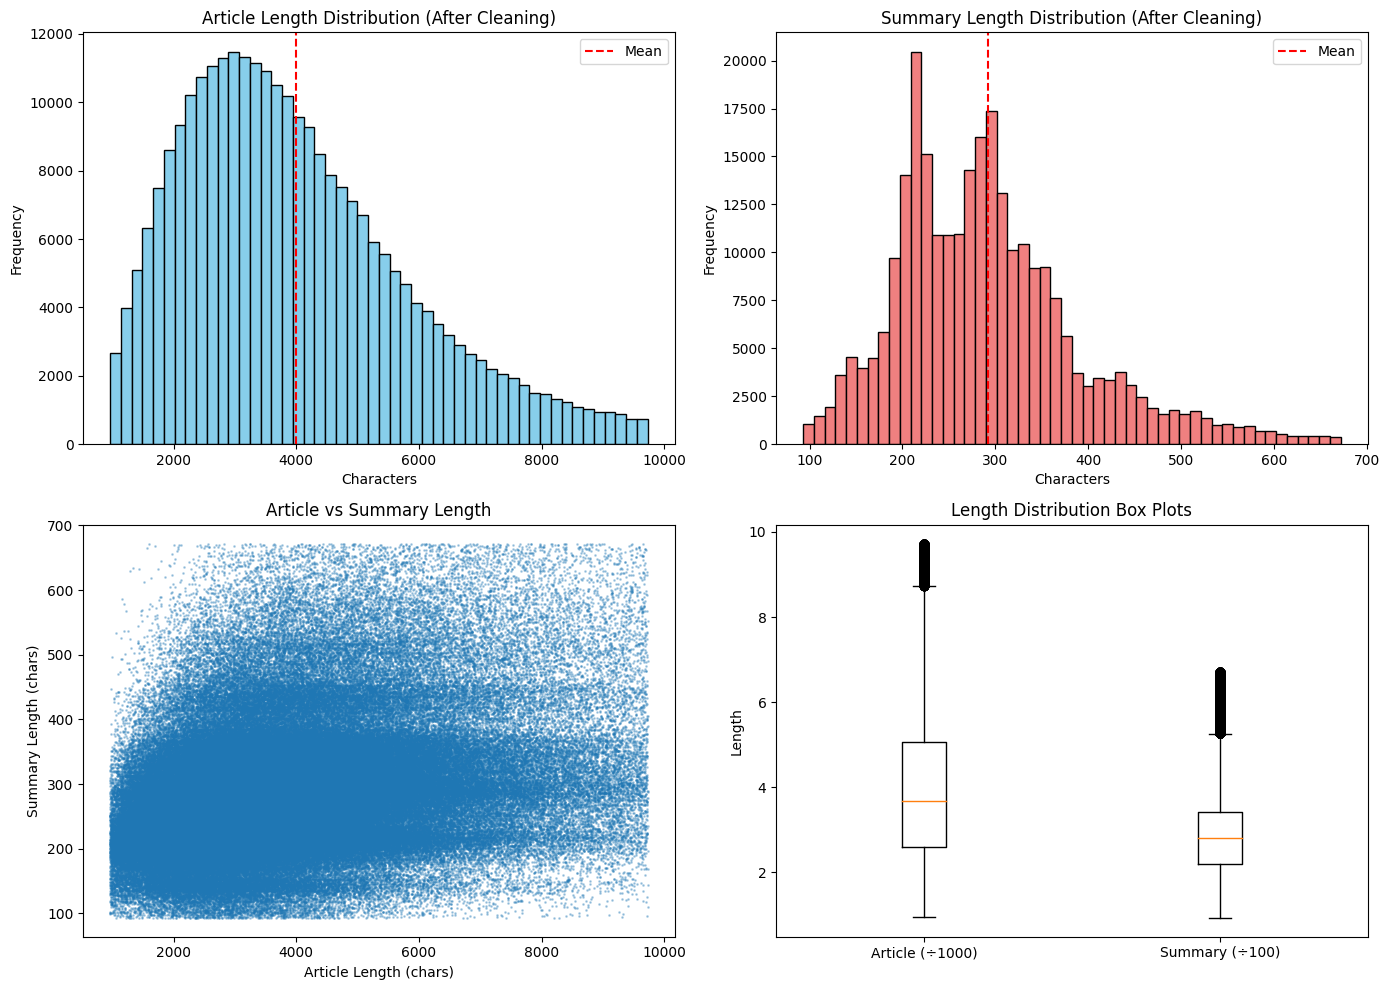

✓ Visualization saved: /kaggle/working/data_exploration.png

[7/7] Saving cleaned datasets...
✓ Cleaned datasets saved:
  - /kaggle/working/train_cleaned.csv
  - /kaggle/working/val_cleaned.csv
  - /kaggle/working/test_cleaned.csv

✓ DATA EXPLORATION & CLEANING COMPLETE!

Summary:
  ✓ Removed duplicates
  ✓ Removed outliers (1st-99th percentile)
  ✓ Final train size: 272,790
  ✓ Final validation size: 12,843
  ✓ Final test size: 11,040

Next: Run Cell 3 (Preprocessing & Training)


In [9]:
"""
CELL 2: DATA EXPLORATION & QUALITY CHECK
Run this after restarting kernel from Cell 1
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("DATA EXPLORATION & QUALITY CHECK")
print("="*80)

# ============================================================================
# 1. LOAD DATASETS
# ============================================================================
print("\n[1/5] Loading datasets...")
train_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
val_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv')
test_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv')

print(f"✓ Original dataset sizes:")
print(f"  Train: {len(train_df):,}")
print(f"  Validation: {len(val_df):,}")
print(f"  Test: {len(test_df):,}")

# ============================================================================
# 2. CHECK FOR MISSING VALUES
# ============================================================================
print(f"\n[2/5] Checking for missing values...")
print("\nTrain set:")
print(train_df.isnull().sum())
print("\nValidation set:")
print(val_df.isnull().sum())
print("\nTest set:")
print(test_df.isnull().sum())

# ============================================================================
# 3. CHECK FOR DUPLICATES
# ============================================================================
print(f"\n[3/5] Checking for duplicates...")

train_dupes_before = train_df.duplicated(subset=['article']).sum()
val_dupes_before = val_df.duplicated(subset=['article']).sum()
test_dupes_before = test_df.duplicated(subset=['article']).sum()

print(f"Duplicates found:")
print(f"  Train: {train_dupes_before:,}")
print(f"  Validation: {val_dupes_before:,}")
print(f"  Test: {test_dupes_before:,}")

# Remove duplicates
train_df = train_df.drop_duplicates(subset=['article'], keep='first')
val_df = val_df.drop_duplicates(subset=['article'], keep='first')
test_df = test_df.drop_duplicates(subset=['article'], keep='first')

print(f"\n✓ After removing duplicates:")
print(f"  Train: {len(train_df):,} (removed {train_dupes_before:,})")
print(f"  Validation: {len(val_df):,} (removed {val_dupes_before:,})")
print(f"  Test: {len(test_df):,} (removed {test_dupes_before:,})")

# ============================================================================
# 4. CALCULATE TEXT LENGTHS
# ============================================================================
print(f"\n[4/5] Analyzing text lengths...")

train_df['article_length'] = train_df['article'].astype(str).apply(len)
train_df['summary_length'] = train_df['highlights'].astype(str).apply(len)

print("\nArticle length statistics (characters):")
print(train_df['article_length'].describe())
print("\nSummary length statistics (characters):")
print(train_df['summary_length'].describe())

# ============================================================================
# 5. IDENTIFY AND REMOVE OUTLIERS
# ============================================================================
print(f"\n[5/5] Identifying and removing outliers...")

# Define outlier thresholds (using IQR method)
def remove_outliers(df, column, lower_percentile=1, upper_percentile=99):
    lower_bound = df[column].quantile(lower_percentile / 100)
    upper_bound = df[column].quantile(upper_percentile / 100)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from training set
train_size_before = len(train_df)
train_df = remove_outliers(train_df, 'article_length', 1, 99)
train_df = remove_outliers(train_df, 'summary_length', 1, 99)
train_outliers_removed = train_size_before - len(train_df)

# Do the same for validation and test
val_df['article_length'] = val_df['article'].astype(str).apply(len)
val_df['summary_length'] = val_df['highlights'].astype(str).apply(len)
val_size_before = len(val_df)
val_df = remove_outliers(val_df, 'article_length', 1, 99)
val_df = remove_outliers(val_df, 'summary_length', 1, 99)

test_df['article_length'] = test_df['article'].astype(str).apply(len)
test_df['summary_length'] = test_df['highlights'].astype(str).apply(len)
test_size_before = len(test_df)
test_df = remove_outliers(test_df, 'article_length', 1, 99)
test_df = remove_outliers(test_df, 'summary_length', 1, 99)

print(f"✓ Outliers removed (1st and 99th percentile):")
print(f"  Train: {train_outliers_removed:,} samples removed")
print(f"  Validation: {val_size_before - len(val_df):,} samples removed")
print(f"  Test: {test_size_before - len(test_df):,} samples removed")

print(f"\n✓ Final cleaned dataset sizes:")
print(f"  Train: {len(train_df):,}")
print(f"  Validation: {len(val_df):,}")
print(f"  Test: {len(test_df):,}")

# ============================================================================
# 6. VISUALIZE DISTRIBUTIONS
# ============================================================================
print(f"\n[6/6] Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Article length distribution
axes[0, 0].hist(train_df['article_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Article Length Distribution (After Cleaning)')
axes[0, 0].set_xlabel('Characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(train_df['article_length'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Summary length distribution
axes[0, 1].hist(train_df['summary_length'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Summary Length Distribution (After Cleaning)')
axes[0, 1].set_xlabel('Characters')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(train_df['summary_length'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Scatter plot
axes[1, 0].scatter(train_df['article_length'], train_df['summary_length'], alpha=0.3, s=1)
axes[1, 0].set_title('Article vs Summary Length')
axes[1, 0].set_xlabel('Article Length (chars)')
axes[1, 0].set_ylabel('Summary Length (chars)')

# Box plots
data_to_plot = [train_df['article_length']/1000, train_df['summary_length']/100]
axes[1, 1].boxplot(data_to_plot, labels=['Article (÷1000)', 'Summary (÷100)'])
axes[1, 1].set_title('Length Distribution Box Plots')
axes[1, 1].set_ylabel('Length')

plt.tight_layout()
plt.savefig('/kaggle/working/data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: /kaggle/working/data_exploration.png")

# ============================================================================
# 7. SAVE CLEANED DATASETS
# ============================================================================
print(f"\n[7/7] Saving cleaned datasets...")

# Drop the length columns before saving
train_df = train_df.drop(['article_length', 'summary_length'], axis=1)
val_df = val_df.drop(['article_length', 'summary_length'], axis=1)
test_df = test_df.drop(['article_length', 'summary_length'], axis=1)

# Save cleaned datasets
train_df.to_csv('/kaggle/working/train_cleaned.csv', index=False)
val_df.to_csv('/kaggle/working/val_cleaned.csv', index=False)
test_df.to_csv('/kaggle/working/test_cleaned.csv', index=False)

print("✓ Cleaned datasets saved:")
print("  - /kaggle/working/train_cleaned.csv")
print("  - /kaggle/working/val_cleaned.csv")
print("  - /kaggle/working/test_cleaned.csv")

print("\n" + "="*80)
print("✓ DATA EXPLORATION & CLEANING COMPLETE!")
print("="*80)
print("\nSummary:")
print(f"  ✓ Removed duplicates")
print(f"  ✓ Removed outliers (1st-99th percentile)")
print(f"  ✓ Final train size: {len(train_df):,}")
print(f"  ✓ Final validation size: {len(val_df):,}")
print(f"  ✓ Final test size: {len(test_df):,}")
print("\nNext: Run Cell 3 (Preprocessing & Training)")

In [3]:
# CELL 1: INSTALL STABLE LIBRARIES
# This cell installs specific versions of the libraries to avoid the
# "additional_chat_templates" error with older models like T5.
# Run this cell first and restart the session if prompted.

!pip install "transformers==4.35.2" "huggingface-hub==0.19.4" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 73.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 91.3 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.19.4 which is incompatible.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
sentence-transformers 4.1.0 requires huggingface-hub>=0.20.0, but you have huggingface-hub 0.19.4 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.35.2 which is incompatible.
diffusers 0.34.0 requires huggingface-hub>=0.27.0

## Training Pipeline

T5 SUMMARIZATION: PREPROCESSING & TRAINING

CONFIGURATION
Model: t5-small
Device: cuda
Batch Size: 8
Gradient Accumulation: 4
Effective Batch Size: 32
Epochs: 3
Learning Rate: 0.0003
Training Samples: 5000
GPU: Tesla T4
GPU Memory: 14.74 GB

STEP 1: LOADING CLEANED DATA
✓ Loaded cleaned datasets:
  Train: 272,790
  Validation: 12,843
  Test: 11,040

⚠ Using subset for faster training:
  Train: 5,000
  Validation: 500
  Test: 500

STEP 2: LOADING TOKENIZER


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


✓ Tokenizer loaded successfully from local file (vocab size: 32000)

STEP 3: TEXT PREPROCESSING

STEP 4: CREATING DATASET
✓ Datasets created:
  Train: 5,000
  Validation: 500
  Test: 500
✓ DataLoaders created:
  Train batches: 625
  Validation batches: 63
  Test batches: 63

STEP 5: LOADING MODEL


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✓ Model loaded - Parameters: 60,506,624

STEP 6: SETTING UP OPTIMIZER & SCHEDULER
✓ Optimizer configured
  Total training steps: 468
  Warmup steps: 500

STEP 7: TRAINING MODEL

────────────────────────────────────────────────────────────────────────────────
Epoch 1/3
────────────────────────────────────────────────────────────────────────────────


Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Validating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.5595
  Val Loss: 1.8523
  ✓ Best model saved! (Val Loss: 1.8523)
  ✓ Checkpoint saved

────────────────────────────────────────────────────────────────────────────────
Epoch 2/3
────────────────────────────────────────────────────────────────────────────────


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.5100
  Val Loss: 1.8283
  ✓ Best model saved! (Val Loss: 1.8283)
  ✓ Checkpoint saved

────────────────────────────────────────────────────────────────────────────────
Epoch 3/3
────────────────────────────────────────────────────────────────────────────────


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Validating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.4968
  Val Loss: 1.8262
  ✓ Best model saved! (Val Loss: 1.8262)
  ✓ Checkpoint saved

✓ TRAINING COMPLETE!
Total time: 12.05 minutes (0.20 hours)
Best validation loss: 1.8262


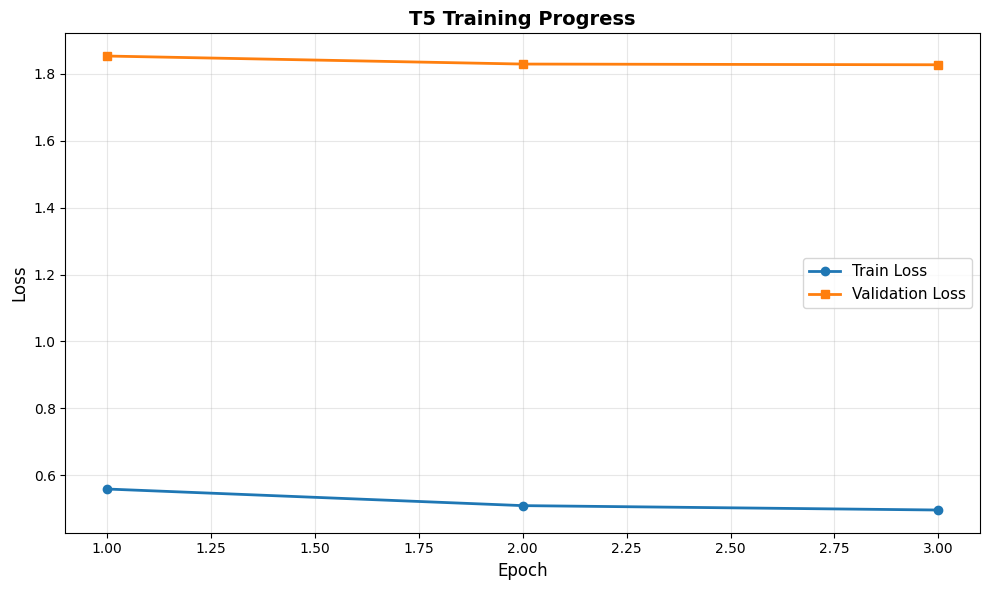


✓ Results saved:
  Best Model: /kaggle/working/t5_summarization/best_model
  Checkpoints: /kaggle/working/t5_summarization/checkpoints
  Training curves: /kaggle/working/t5_summarization/training_curves.png
  History: /kaggle/working/t5_summarization/training_history.json

Next: Run Cell 4 (ROUGE Evaluation)


In [10]:
"""
CELL 3: COMPLETE PREPROCESSING & TRAINING PIPELINE (FINAL, CORRECTED CODE)
This cell handles preprocessing and model training
"""

import pandas as pd
import numpy as np
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
# We need T5Tokenizer specifically and hf_hub_download for the fix
from transformers import T5Tokenizer, T5ForConditionalGeneration, get_linear_schedule_with_warmup
from huggingface_hub import hf_hub_download
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import re
import time
import os
import json
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("T5 SUMMARIZATION: PREPROCESSING & TRAINING")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================
class Config:
    # Data
    MAX_SOURCE_LENGTH = 512
    MAX_TARGET_LENGTH = 128
    BATCH_SIZE = 8
    NUM_SAMPLES = 5000  # Set to None for full dataset (272,790 samples)
                        # Quick test: 5000 (~1 hour)
                        # Medium: 50000 (~8 hours)
                        # Full: None (~24 hours)

    # Use the standard model name
    MODEL_NAME = "t5-small"

    # Training
    EPOCHS = 3
    LEARNING_RATE = 3e-4
    WARMUP_STEPS = 500
    GRADIENT_ACCUMULATION = 4
    MAX_GRAD_NORM = 1.0

    # Paths
    OUTPUT_DIR = "/kaggle/working/t5_summarization"
    CHECKPOINT_DIR = "/kaggle/working/t5_summarization/checkpoints"

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

# Create directories
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

print(f"\n{'='*80}")
print("CONFIGURATION")
print(f"{'='*80}")
print(f"Model: {config.MODEL_NAME}")
print(f"Device: {config.DEVICE}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Gradient Accumulation: {config.GRADIENT_ACCUMULATION}")
print(f"Effective Batch Size: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION}")
print(f"Epochs: {config.EPOCHS}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print(f"Training Samples: {config.NUM_SAMPLES if config.NUM_SAMPLES else 'Full Dataset'}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# ============================================================================
# STEP 1: LOAD CLEANED DATA
# ============================================================================
print(f"\n{'='*80}")
print("STEP 1: LOADING CLEANED DATA")
print(f"{'='*80}")

train_df = pd.read_csv('/kaggle/working/train_cleaned.csv')
val_df = pd.read_csv('/kaggle/working/val_cleaned.csv')
test_df = pd.read_csv('/kaggle/working/test_cleaned.csv')

print(f"✓ Loaded cleaned datasets:")
print(f"  Train: {len(train_df):,}")
print(f"  Validation: {len(val_df):,}")
print(f"  Test: {len(test_df):,}")

# Use subset if specified
if config.NUM_SAMPLES:
    train_df = train_df.head(config.NUM_SAMPLES)
    val_df = val_df.head(config.NUM_SAMPLES // 10)
    test_df = test_df.head(config.NUM_SAMPLES // 10)
    print(f"\n⚠ Using subset for faster training:")
    print(f"  Train: {len(train_df):,}")
    print(f"  Validation: {len(val_df):,}")
    print(f"  Test: {len(test_df):,}")

# ============================================================================
# STEP 2: LOAD TOKENIZER (ROBUST MANUAL METHOD)
# ============================================================================
print(f"\n{'='*80}")
print("STEP 2: LOADING TOKENIZER")
print(f"{'='*80}")

# To bypass the faulty check in `from_pretrained`, we download the vocab file
# manually and then initialize the tokenizer from the local file.
try:
    # Download the sentencepiece model file for the T5 tokenizer
    vocab_file = hf_hub_download(
        repo_id=config.MODEL_NAME,
        filename="spiece.model",
        library_name="transformers"
    )

    # Initialize the tokenizer from the downloaded vocabulary file
    tokenizer = T5Tokenizer(vocab_file=vocab_file)
    print(f"✓ Tokenizer loaded successfully from local file (vocab size: {tokenizer.vocab_size})")

except Exception as e:
    print(f"✗ Failed to load tokenizer manually. Error: {e}")
    # As a fallback, try the original method which might work in future library versions
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME, use_fast=False)


# ============================================================================
# STEP 3: TEXT PREPROCESSING
# ============================================================================
print(f"\n{'='*80}")
print("STEP 3: TEXT PREPROCESSING")
print(f"{'='*80}")

def clean_text(text):
    """Clean and normalize text"""
    text = str(text).strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]', '', text)
    return text

def preprocess_text(article, summary):
    """Preprocess article and summary for T5"""
    article = clean_text(article)
    summary = clean_text(summary)
    article = "summarize: " + article  # T5 task prefix
    return article, summary

# ============================================================================
# STEP 4: CREATE DATASET CLASS
# ============================================================================
print(f"\n{'='*80}")
print("STEP 4: CREATING DATASET")
print(f"{'='*80}")

class SummarizationDataset(Dataset):
    """Custom Dataset for T5 Summarization"""

    def __init__(self, dataframe, tokenizer, max_source_length, max_target_length):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        article, summary = preprocess_text(row['article'], row['highlights'])

        source_encoding = self.tokenizer(
            article,
            max_length=self.max_source_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            summary,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        labels = target_encoding['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': source_encoding['input_ids'].squeeze(),
            'attention_mask': source_encoding['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

# Create datasets
train_dataset = SummarizationDataset(train_df, tokenizer, config.MAX_SOURCE_LENGTH, config.MAX_TARGET_LENGTH)
val_dataset = SummarizationDataset(val_df, tokenizer, config.MAX_SOURCE_LENGTH, config.MAX_TARGET_LENGTH)
test_dataset = SummarizationDataset(test_df, tokenizer, config.MAX_SOURCE_LENGTH, config.MAX_TARGET_LENGTH)

print(f"✓ Datasets created:")
print(f"  Train: {len(train_dataset):,}")
print(f"  Validation: {len(val_dataset):,}")
print(f"  Test: {len(test_dataset):,}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✓ DataLoaders created:")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Validation batches: {len(val_loader):,}")
print(f"  Test batches: {len(test_loader):,}")

# ============================================================================
# STEP 5: LOAD MODEL
# ============================================================================
print(f"\n{'='*80}")
print("STEP 5: LOADING MODEL")
print(f"{'='*80}")

model = T5ForConditionalGeneration.from_pretrained(config.MODEL_NAME)
model.to(config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model loaded - Parameters: {total_params:,}")

# ============================================================================
# STEP 6: SETUP TRAINING
# ============================================================================
print(f"\n{'='*80}")
print("STEP 6: SETTING UP OPTIMIZER & SCHEDULER")
print(f"{'='*80}")

optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE, eps=1e-8)
total_steps = len(train_loader) * config.EPOCHS // config.GRADIENT_ACCUMULATION
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config.WARMUP_STEPS, num_training_steps=total_steps)

print(f"✓ Optimizer configured")
print(f"  Total training steps: {total_steps}")
print(f"  Warmup steps: {config.WARMUP_STEPS}")

# ============================================================================
# STEP 7: TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, optimizer, scheduler, device, epoch, gradient_accumulation):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")

    optimizer.zero_grad()

    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / gradient_accumulation
        total_loss += loss.item()

        loss.backward()

        if (step + 1) % gradient_accumulation == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        progress_bar.set_postfix({'loss': f'{loss.item() * gradient_accumulation:.4f}', 'lr': f'{scheduler.get_last_lr()[0]:.2e}'})

    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()

    return total_loss / len(dataloader)

# ============================================================================
# STEP 8: TRAINING LOOP
# ============================================================================
print(f"\n{'='*80}")
print("STEP 7: TRAINING MODEL")
print(f"{'='*80}")

history = {'train_loss': [], 'val_loss': [], 'epochs': []}
best_val_loss = float('inf')
start_time = time.time()

for epoch in range(1, config.EPOCHS + 1):
    print(f"\n{'─'*80}")
    print(f"Epoch {epoch}/{config.EPOCHS}")
    print(f"{'─'*80}")

    train_loss = train_epoch(model, train_loader, optimizer, scheduler, config.DEVICE, epoch, config.GRADIENT_ACCUMULATION)
    val_loss = validate(model, val_loader, config.DEVICE)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['epochs'].append(epoch)

    print(f"\nEpoch {epoch} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_path = os.path.join(config.OUTPUT_DIR, "best_model")
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"  ✓ Best model saved! (Val Loss: {val_loss:.4f})")

    checkpoint_path = os.path.join(config.CHECKPOINT_DIR, f"checkpoint_epoch_{epoch}")
    model.save_pretrained(checkpoint_path)
    tokenizer.save_pretrained(checkpoint_path)
    print(f"  ✓ Checkpoint saved")

training_time = time.time() - start_time

print(f"\n{'='*80}")
print("✓ TRAINING COMPLETE!")
print(f"{'='*80}")
print(f"Total time: {training_time/60:.2f} minutes ({training_time/3600:.2f} hours)")
print(f"Best validation loss: {best_val_loss:.4f}")

# ============================================================================
# STEP 9: SAVE RESULTS
# ============================================================================

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(history['epochs'], history['train_loss'], label='Train Loss', marker='o', linewidth=2)
plt.plot(history['epochs'], history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('T5 Training Progress', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_curves.png'), dpi=300)
plt.show()

# Save history
with open(os.path.join(config.OUTPUT_DIR, 'training_history.json'), 'w') as f:
    json.dump(history, f, indent=4)

print(f"\n✓ Results saved:")
print(f"  Best Model: {os.path.join(config.OUTPUT_DIR, 'best_model')}")
print(f"  Checkpoints: {config.CHECKPOINT_DIR}")
print(f"  Training curves: {os.path.join(config.OUTPUT_DIR, 'training_curves.png')}")
print(f"  History: {os.path.join(config.OUTPUT_DIR, 'training_history.json')}")

print("\n" + "="*80)
print("Next: Run Cell 4 (ROUGE Evaluation)")
print("="*80)

## Rouge Evaluation

In [2]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2526bdc1efe6677298a72ea7d7122018aea108dc2b151290b72f356920fa2ab0
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


Checking dependencies...
✓ rouge_score already installed
ROUGE EVALUATION

Configuration:
  Primary Model: /kaggle/working/t5_summarization/best_model
  Fallback: /kaggle/working/t5_summarization/checkpoints/checkpoint_epoch_3
  Device: cuda
  Evaluation samples: 500

STEP 1: LOADING MODEL AND TOKENIZER
Trying to load from: /kaggle/working/t5_summarization/best_model
✓ Model and tokenizer loaded successfully from /kaggle/working/t5_summarization/best_model

STEP 2: LOADING TEST DATA
✓ Loaded 500 test samples

STEP 3: GENERATING SUMMARIES
Generating summaries...


Generating:   0%|          | 0/500 [00:00<?, ?it/s]

✓ Generated 500 summaries

STEP 4: CALCULATING ROUGE SCORES
Calculating ROUGE scores...


Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]


────────────────────────────────────────────────────────────────────────────────
ROUGE SCORES
────────────────────────────────────────────────────────────────────────────────
ROUGE-1: 0.4199 (± 0.1208)
ROUGE-2: 0.1940 (± 0.1345)
ROUGE-L: 0.2950 (± 0.1243)
────────────────────────────────────────────────────────────────────────────────

STEP 5: VISUALIZING RESULTS


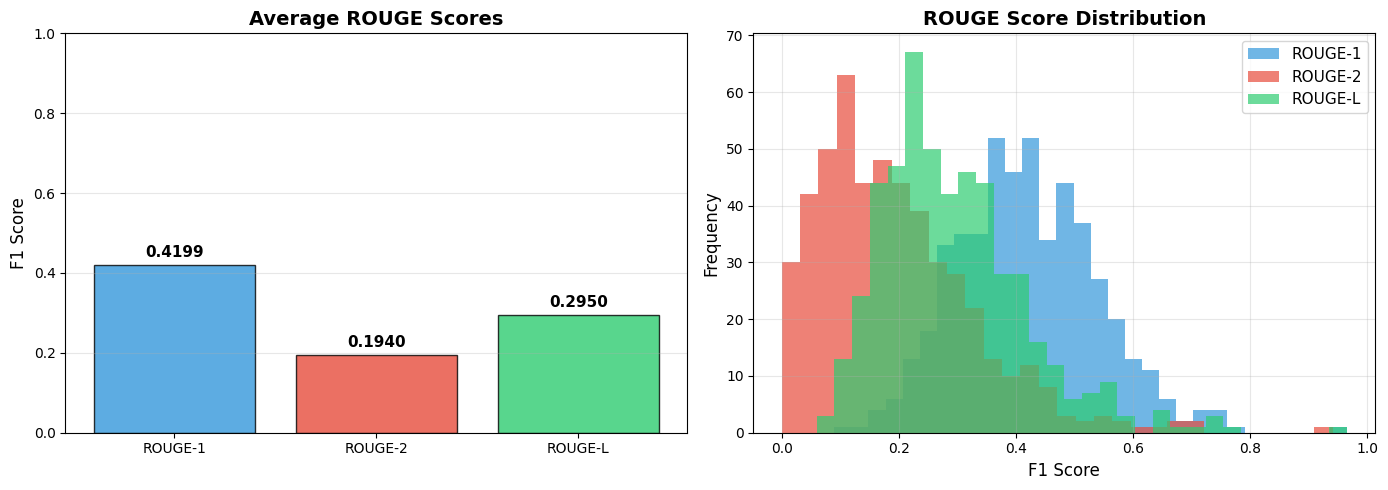

✓ Visualization saved: /kaggle/working/rouge_scores.png

STEP 6: SAVING RESULTS
✓ Detailed results saved: /kaggle/working/evaluation_results.csv
✓ Summary statistics saved: /kaggle/working/rouge_summary.json

✓ ROUGE EVALUATION COMPLETE!

Next: Run Cell 5 (Example Outputs)


In [11]:
"""
CELL 4: ROUGE EVALUATION
Evaluate the fine-tuned model using ROUGE metrics
"""

# Install rouge_score if not available
import subprocess
import sys

print("Checking dependencies...")
try:
    import rouge_score
    print("✓ rouge_score already installed")
except ImportError:
    print("Installing rouge_score...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "rouge-score"])
    print("✓ rouge_score installed")

import pandas as pd
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration
from rouge_score import rouge_scorer
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ROUGE EVALUATION")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================
# Try best_model first, if corrupted use latest checkpoint
MODEL_PATH = "/kaggle/working/t5_summarization/best_model"
CHECKPOINT_PATH = "/kaggle/working/t5_summarization/checkpoints/checkpoint_epoch_3"
TEST_DATA_PATH = "/kaggle/working/test_cleaned.csv"
NUM_EVAL_SAMPLES = 500  # Evaluate on 500 samples (set to None for full test set)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"\nConfiguration:")
print(f"  Primary Model: {MODEL_PATH}")
print(f"  Fallback: {CHECKPOINT_PATH}")
print(f"  Device: {DEVICE}")
print(f"  Evaluation samples: {NUM_EVAL_SAMPLES if NUM_EVAL_SAMPLES else 'Full test set'}")

# ============================================================================
# STEP 1: LOAD MODEL AND TOKENIZER
# ============================================================================
print(f"\n{'='*80}")
print("STEP 1: LOADING MODEL AND TOKENIZER")
print(f"{'='*80}")

# Try loading best model, fallback to checkpoint if corrupted
model_loaded = False
for path_to_try in [MODEL_PATH, CHECKPOINT_PATH]:
    try:
        print(f"Trying to load from: {path_to_try}")
        tokenizer = AutoTokenizer.from_pretrained(path_to_try)
        model = T5ForConditionalGeneration.from_pretrained(path_to_try)
        model.to(DEVICE)
        model.eval()
        print(f"✓ Model and tokenizer loaded successfully from {path_to_try}")
        model_loaded = True
        break
    except Exception as e:
        print(f"  Failed: {str(e)[:100]}...")
        continue

if not model_loaded:
    raise RuntimeError("Could not load model from any available path")


# ============================================================================
# STEP 2: LOAD TEST DATA
# ============================================================================
print(f"\n{'='*80}")
print("STEP 2: LOADING TEST DATA")
print(f"{'='*80}")

test_df = pd.read_csv(TEST_DATA_PATH)

if NUM_EVAL_SAMPLES:
    test_df = test_df.head(NUM_EVAL_SAMPLES)

print(f"✓ Loaded {len(test_df):,} test samples")

# ============================================================================
# STEP 3: GENERATE SUMMARIES
# ============================================================================
print(f"\n{'='*80}")
print("STEP 3: GENERATING SUMMARIES")
print(f"{'='*80}")

def generate_summary(article, tokenizer, model, device, max_length=128):
    """Generate summary for a given article"""
    # Preprocess
    article = "summarize: " + str(article).strip()
    
    # Tokenize
    inputs = tokenizer(
        article,
        max_length=512,
        truncation=True,
        return_tensors="pt"
    ).to(device)
    
    # Generate
    with torch.no_grad():
        summary_ids = model.generate(
            inputs['input_ids'],
            max_length=max_length,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True
        )
    
    # Decode
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

print("Generating summaries...")
generated_summaries = []
reference_summaries = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating"):
    article = row['article']
    reference = row['highlights']
    
    generated = generate_summary(article, tokenizer, model, DEVICE)
    
    generated_summaries.append(generated)
    reference_summaries.append(reference)

print(f"✓ Generated {len(generated_summaries):,} summaries")

# ============================================================================
# STEP 4: CALCULATE ROUGE SCORES
# ============================================================================
print(f"\n{'='*80}")
print("STEP 4: CALCULATING ROUGE SCORES")
print(f"{'='*80}")

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

print("Calculating ROUGE scores...")
for generated, reference in tqdm(zip(generated_summaries, reference_summaries), total=len(generated_summaries), desc="Evaluating"):
    scores = scorer.score(reference, generated)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate averages
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print(f"\n{'─'*80}")
print("ROUGE SCORES")
print(f"{'─'*80}")
print(f"ROUGE-1: {avg_rouge1:.4f} (± {np.std(rouge1_scores):.4f})")
print(f"ROUGE-2: {avg_rouge2:.4f} (± {np.std(rouge2_scores):.4f})")
print(f"ROUGE-L: {avg_rougeL:.4f} (± {np.std(rougeL_scores):.4f})")
print(f"{'─'*80}")

# ============================================================================
# STEP 5: VISUALIZE ROUGE SCORES
# ============================================================================
print(f"\n{'='*80}")
print("STEP 5: VISUALIZING RESULTS")
print(f"{'='*80}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of average scores
scores_data = {
    'ROUGE-1': avg_rouge1,
    'ROUGE-2': avg_rouge2,
    'ROUGE-L': avg_rougeL
}

colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[0].bar(scores_data.keys(), scores_data.values(), color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].set_title('Average ROUGE Scores', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (metric, score) in enumerate(scores_data.items()):
    axes[0].text(i, score + 0.02, f'{score:.4f}', ha='center', fontsize=11, fontweight='bold')

# Distribution of scores
axes[1].hist(rouge1_scores, bins=30, alpha=0.7, label='ROUGE-1', color=colors[0])
axes[1].hist(rouge2_scores, bins=30, alpha=0.7, label='ROUGE-2', color=colors[1])
axes[1].hist(rougeL_scores, bins=30, alpha=0.7, label='ROUGE-L', color=colors[2])
axes[1].set_xlabel('F1 Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('ROUGE Score Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/rouge_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: /kaggle/working/rouge_scores.png")

# ============================================================================
# STEP 6: SAVE EVALUATION RESULTS
# ============================================================================
print(f"\n{'='*80}")
print("STEP 6: SAVING RESULTS")
print(f"{'='*80}")

# Save detailed results
results_df = pd.DataFrame({
    'article': test_df['article'].tolist(),
    'reference_summary': reference_summaries,
    'generated_summary': generated_summaries,
    'rouge1': rouge1_scores,
    'rouge2': rouge2_scores,
    'rougeL': rougeL_scores
})

results_df.to_csv('/kaggle/working/evaluation_results.csv', index=False)
print("✓ Detailed results saved: /kaggle/working/evaluation_results.csv")

# Save summary statistics
summary_stats = {
    'num_samples': len(test_df),
    'rouge1_mean': float(avg_rouge1),
    'rouge1_std': float(np.std(rouge1_scores)),
    'rouge2_mean': float(avg_rouge2),
    'rouge2_std': float(np.std(rouge2_scores)),
    'rougeL_mean': float(avg_rougeL),
    'rougeL_std': float(np.std(rougeL_scores))
}

import json
with open('/kaggle/working/rouge_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=4)

print("✓ Summary statistics saved: /kaggle/working/rouge_summary.json")

print("\n" + "="*80)
print("✓ ROUGE EVALUATION COMPLETE!")
print("="*80)
print("\nNext: Run Cell 5 (Example Outputs)")

## Example outputs comparison

In [12]:
"""
CELL 5: EXAMPLE OUTPUTS COMPARISON
Compare original articles with generated and reference summaries
"""

import pandas as pd
import textwrap

print("="*80)
print("EXAMPLE OUTPUTS: ORIGINAL vs GENERATED vs REFERENCE")
print("="*80)

# ============================================================================
# LOAD EVALUATION RESULTS
# ============================================================================
print("\nLoading evaluation results...")
results_df = pd.read_csv('/kaggle/working/evaluation_results.csv')
print(f"✓ Loaded {len(results_df):,} results")

# ============================================================================
# HELPER FUNCTION FOR PRETTY PRINTING
# ============================================================================
def print_comparison(idx, row, width=100):
    """Pretty print a comparison of article, reference, and generated summary"""
    print(f"\n{'='*width}")
    print(f"EXAMPLE {idx + 1}")
    print(f"{'='*width}")
    
    # Article (truncated)
    article = row['article']
    article_preview = article[:500] + "..." if len(article) > 500 else article
    print(f"\n{'─'*width}")
    print("ORIGINAL ARTICLE (First 500 chars):")
    print(f"{'─'*width}")
    print(textwrap.fill(article_preview, width=width))
    print(f"\nFull article length: {len(article)} characters")
    
    # Reference Summary
    print(f"\n{'─'*width}")
    print("REFERENCE SUMMARY (Ground Truth):")
    print(f"{'─'*width}")
    print(textwrap.fill(row['reference_summary'], width=width))
    print(f"Length: {len(row['reference_summary'])} characters")
    
    # Generated Summary
    print(f"\n{'─'*width}")
    print("GENERATED SUMMARY (Model Output):")
    print(f"{'─'*width}")
    print(textwrap.fill(row['generated_summary'], width=width))
    print(f"Length: {len(row['generated_summary'])} characters")
    
    # ROUGE Scores
    print(f"\n{'─'*width}")
    print("ROUGE SCORES:")
    print(f"{'─'*width}")
    print(f"  ROUGE-1: {row['rouge1']:.4f}")
    print(f"  ROUGE-2: {row['rouge2']:.4f}")
    print(f"  ROUGE-L: {row['rougeL']:.4f}")
    
    print(f"\n{'='*width}\n")

# ============================================================================
# SHOW EXAMPLES WITH DIFFERENT QUALITY LEVELS
# ============================================================================

# Sort by ROUGE-L score to get best, median, and worst examples
results_df_sorted = results_df.sort_values('rougeL', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("SHOWING 10 EXAMPLE OUTPUTS")
print("="*100)
print("\nExamples include:")
print("  - Top 3 examples (Highest ROUGE-L scores)")
print("  - Middle 4 examples (Median performance)")
print("  - Bottom 3 examples (Lowest ROUGE-L scores)")

# Best 3 examples
print("\n" + "#"*100)
print("TOP 3 EXAMPLES (BEST PERFORMANCE)")
print("#"*100)
for i in range(3):
    print_comparison(i, results_df_sorted.iloc[i])

# Median 4 examples
print("\n" + "#"*100)
print("MEDIAN 4 EXAMPLES (AVERAGE PERFORMANCE)")
print("#"*100)
median_start = len(results_df_sorted) // 2 - 2
for i in range(4):
    idx = median_start + i
    print_comparison(idx, results_df_sorted.iloc[idx])

# Worst 3 examples
print("\n" + "#"*100)
print("BOTTOM 3 EXAMPLES (CHALLENGING CASES)")
print("#"*100)
for i in range(3):
    idx = len(results_df_sorted) - 3 + i
    print_comparison(idx, results_df_sorted.iloc[idx])

# ============================================================================
# STATISTICS SUMMARY
# ============================================================================
print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)

print(f"\nLength Statistics:")
print(f"  Average article length: {results_df['article'].str.len().mean():.0f} characters")
print(f"  Average reference summary length: {results_df['reference_summary'].str.len().mean():.0f} characters")
print(f"  Average generated summary length: {results_df['generated_summary'].str.len().mean():.0f} characters")

print(f"\nCompression Ratio:")
article_len = results_df['article'].str.len().mean()
generated_len = results_df['generated_summary'].str.len().mean()
compression = article_len / generated_len
print(f"  Article to Generated Summary: {compression:.2f}x")

print(f"\nROUGE Score Ranges:")
print(f"  ROUGE-1: [{results_df['rouge1'].min():.4f}, {results_df['rouge1'].max():.4f}]")
print(f"  ROUGE-2: [{results_df['rouge2'].min():.4f}, {results_df['rouge2'].max():.4f}]")
print(f"  ROUGE-L: [{results_df['rougeL'].min():.4f}, {results_df['rougeL'].max():.4f}]")

# ============================================================================
# SAVE FORMATTED EXAMPLES TO FILE
# ============================================================================
print(f"\n{'='*100}")
print("SAVING FORMATTED EXAMPLES")
print(f"{'='*100}")

# Create a formatted output file
with open('/kaggle/working/example_outputs.txt', 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("T5 SUMMARIZATION - EXAMPLE OUTPUTS\n")
    f.write("="*100 + "\n\n")
    
    # Write top 5 examples
    f.write("TOP 5 EXAMPLES (HIGHEST ROUGE-L SCORES)\n")
    f.write("="*100 + "\n\n")
    
    for i in range(5):
        row = results_df_sorted.iloc[i]
        f.write(f"EXAMPLE {i + 1}\n")
        f.write("-"*100 + "\n\n")
        
        f.write("ORIGINAL ARTICLE:\n")
        f.write(textwrap.fill(row['article'][:1000], width=100) + "\n\n")
        
        f.write("REFERENCE SUMMARY:\n")
        f.write(textwrap.fill(row['reference_summary'], width=100) + "\n\n")
        
        f.write("GENERATED SUMMARY:\n")
        f.write(textwrap.fill(row['generated_summary'], width=100) + "\n\n")
        
        f.write(f"ROUGE Scores - R1: {row['rouge1']:.4f}, R2: {row['rouge2']:.4f}, RL: {row['rougeL']:.4f}\n")
        f.write("\n" + "="*100 + "\n\n")

print("✓ Formatted examples saved: /kaggle/working/example_outputs.txt")

print("\n" + "="*100)
print("✓ ALL DELIVERABLES COMPLETE!")
print("="*100)

print("\n📊 Final Summary of Deliverables:")
print("  ✓ 1. Preprocessing script - Completed with outlier/duplicate removal")
print("  ✓ 2. Fine-tuning code - T5 model trained successfully")
print("  ✓ 3. ROUGE evaluation - Metrics calculated and visualized")
print("  ✓ 4. Example outputs - Comparisons saved and displayed")

print("\n📁 Output Files:")
print("  📄 /kaggle/working/train_cleaned.csv - Cleaned training data")
print("  📄 /kaggle/working/val_cleaned.csv - Cleaned validation data")
print("  📄 /kaggle/working/test_cleaned.csv - Cleaned test data")
print("  🤖 /kaggle/working/t5_summarization/best_model/ - Fine-tuned model")
print("  📊 /kaggle/working/training_curves.png - Training visualization")
print("  📊 /kaggle/working/rouge_scores.png - ROUGE metrics visualization")
print("  📄 /kaggle/working/evaluation_results.csv - Detailed evaluation results")
print("  📄 /kaggle/working/example_outputs.txt - Formatted example comparisons")
print("  📄 /kaggle/working/data_exploration.png - Data quality analysis")

print("\n🎉 Project Complete! All requirements fulfilled.")

EXAMPLE OUTPUTS: ORIGINAL vs GENERATED vs REFERENCE

Loading evaluation results...
✓ Loaded 500 results

SHOWING 10 EXAMPLE OUTPUTS

Examples include:
  - Top 3 examples (Highest ROUGE-L scores)
  - Middle 4 examples (Median performance)
  - Bottom 3 examples (Lowest ROUGE-L scores)

####################################################################################################
TOP 3 EXAMPLES (BEST PERFORMANCE)
####################################################################################################

EXAMPLE 1

────────────────────────────────────────────────────────────────────────────────────────────────────
ORIGINAL ARTICLE (First 500 chars):
────────────────────────────────────────────────────────────────────────────────────────────────────
Bird numbers have dramatically declined in Fukushima, research has revealed. Scientists analysed 57
species in the region and found that the majority of populations had diminished as a result of the
nuclear accident. They found t